[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Logistic Regression Modeli Sonuçları:
Doğruluk Oranı: 0.9506

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2079
           1       0.94      0.96      0.95      2074

    accuracy                           0.95      4153
   macro avg       0.95      0.95      0.95      4153
weighted avg       0.95      0.95      0.95      4153



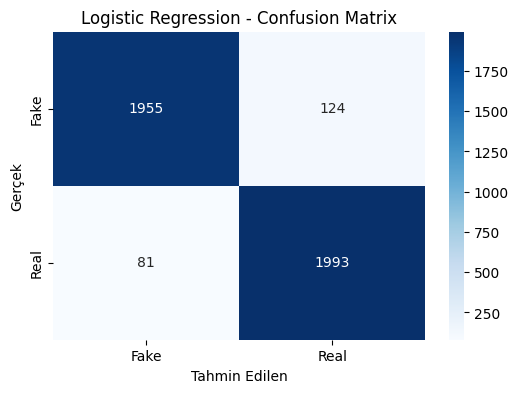


SVM Modeli Sonuçları:
Doğruluk Oranı: 0.9569

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2079
           1       0.95      0.96      0.96      2074

    accuracy                           0.96      4153
   macro avg       0.96      0.96      0.96      4153
weighted avg       0.96      0.96      0.96      4153



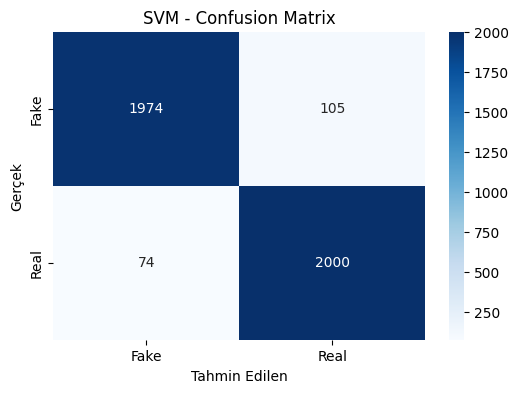

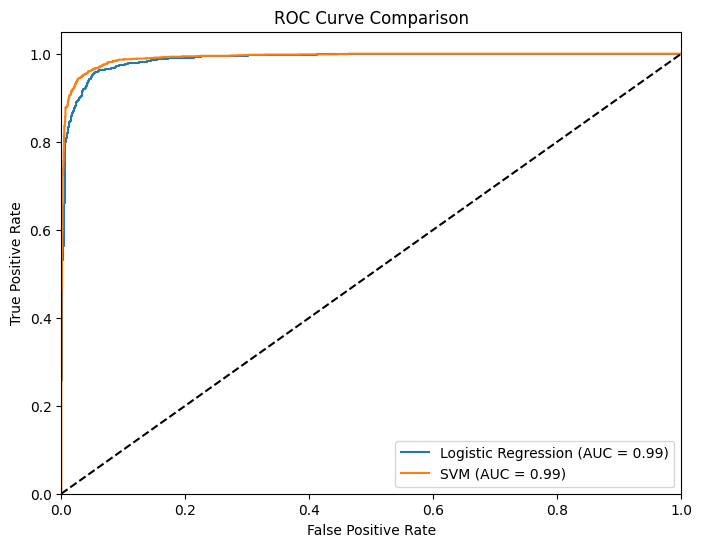

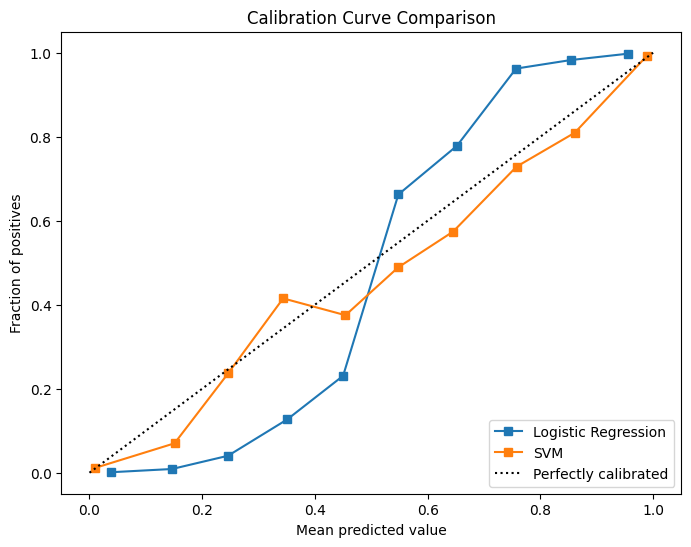


Model Karşılaştırması:
                 Model  Accuracy
1                  SVM  0.956899
0  Logistic Regression  0.950638


In [2]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn import metrics

# Gerekli NLTK verilerini indir
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# CSV dosyasını yükleme (dosya adını kendi veri setine göre değiştir)
df = pd.read_csv("/content/train.csv")

# Haber içeriği ve etiketleri belirleme
X = df["text"]  # Haber metni
y = df["label"]  # Gerçek / Sahte etiketleri

# İngilizce stopwords listesi
en_stopwords = set(stopwords.words('english'))
# Özel eklenmiş stopwords
custom_stopwords = {"news", "said", "report", "year"}  # Örnek ekleme, ihtiyaca göre artırılabilir
en_stopwords.update(custom_stopwords)

# Lemmatizer tanımla
lemmatizer = WordNetLemmatizer()

def preprocess_text(content):
    # Özel karakterleri ve HTML etiketlerini temizleme
    content = re.sub(r'<.*?>', '', content)  # HTML etiketleri temizle
    content = re.sub(r'[^a-zA-Z]', ' ', content)  # Sadece harfleri bırak
    content = content.lower()  # Küçük harfe çevir
    content = content.split()  # Kelimeleri ayır

    # Stopwords temizleme ve Lemmatization
    content = [lemmatizer.lemmatize(word) for word in content if word not in en_stopwords]

    return ' '.join(content)

# Eksik değerleri temizle (X ve y'yi birlikte senkronize et)
df = df.dropna(subset=["text", "label"])

# X ve y'yi ayır
X = df["text"].astype(str)
y = df["label"]

# Veri ön işleme uygula
X = X.apply(preprocess_text)

# TF-IDF vektörizasyonu
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

# Eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelleri tanımla
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(kernel='linear', probability=True)  # Doğrusal SVM
}

# Modelleri eğit ve değerlendir
results = {}
for name, model in models.items():
    # Modeli eğit
    model.fit(X_train, y_train)

    # Tahmin yap
    y_pred = model.predict(X_test)

    # Olasılık tahminleri (calibration curve için)
    if hasattr(model, "predict_proba"):
        prob_pos = model.predict_proba(X_test)[:, 1]
    else:
        prob_pos = model.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

    # Metrikleri hesapla
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Sonuçları sakla
    results[name] = {
        "model": model,
        "accuracy": accuracy,
        "report": report,
        "confusion_matrix": cm,
        "prob_pos": prob_pos
    }

    # Sonuçları yazdır
    print(f"\n{name} Modeli Sonuçları:")
    print("="*50)
    print(f"Doğruluk Oranı: {accuracy:.4f}")
    print("\nSınıflandırma Raporu:")
    print(report)

    # Karmaşıklık Matrisi Görselleştirme
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.xlabel("Tahmin Edilen")
    plt.ylabel("Gerçek")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

# ROC Eğrisi Çizimi
plt.figure(figsize=(8, 6))
for name, result in results.items():
    fpr, tpr, _ = metrics.roc_curve(y_test, result["prob_pos"])
    auc = metrics.roc_auc_score(y_test, result["prob_pos"])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

# Calibration Curve Çizimi
plt.figure(figsize=(8, 6))
for name, result in results.items():
    prob_pos = result["prob_pos"]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{name}")

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.title('Calibration Curve Comparison')
plt.legend(loc="lower right")
plt.show()

# Model Karşılaştırma Tablosu
print("\nModel Karşılaştırması:")
print("="*50)
comparison = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy": [result["accuracy"] for result in results.values()]
}).sort_values("Accuracy", ascending=False)
print(comparison)